In [18]:
# creation de groupes d'études 

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import csv
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr

import importlib
import utils
importlib.reload(utils)
from utils import detect_delimiter, detect_header

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

import umap

In [3]:
factors = pd.read_csv('tables/factors_for_visualization_reduit.csv')
factors.head()

/tmp/ipykernel_1646/1232393483.py:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  factors = pd.read_csv('tables/factors_for_visualization_reduit.csv')


,canton,codgeo,libgeo,acces_medecin_generaliste,acces_soins_infirmiers,nb_seveso,nb_creation_entreprises_industrie_23,nb_creation_entreprises_construction_23,nb_creation_entreprises_transport_hebergement_restauration_23,nb_creation_entreprises_information_communication_23,...,nb_dhebergements_tourisme,nb_emplois,age_0_10,age_11_17,age_18_39,age_40_79,age_80_plus,densite_population,effectif_salaries,impots_moyen
0,108.0,1001,L'Abergement-Clémenciat,1.8,121.5,0.0,0.000000,0.002404,0.000000,0.001202,...,0.000000,0.090144,112.0,77.0,171.0,0.489183,0.046875,52.33,19.0,214.657452
1,101.0,1002,L'Abergement-de-Varey,2.0,109.2,0.0,0.000000,0.000000,0.003745,0.000000,...,0.000000,0.108614,37.0,34.0,52.0,0.460674,0.059925,29.02,6.0,273.932584
2,101.0,1004,Ambérieu-en-Bugey,2.9,208.5,0.0,0.000471,0.001144,0.004107,0.000404,...,0.000269,0.548808,1955.0,1212.0,4344.0,0.404403,0.051771,603.82,4277.0,511.462636
3,122.0,1005,Ambérieux-en-Dombes,3.9,145.8,0.0,0.000527,0.001054,0.002109,0.000000,...,0.003163,0.137586,257.0,157.0,466.0,0.435424,0.040063,119.31,150.0,283.331049
4,104.0,1006,Ambléon,0.8,47.0,0.0,0.008850,0.000000,0.000000,0.000000,...,0.000000,0.044248,10.0,2.0,28.0,0.592920,0.053097,19.15,0.0,289.575221


In [4]:
# Copier le df original 
df = factors.copy()
print(df.shape)

(35031, 99)


In [5]:
groupes_variables = {
    "canton": ["canton"], "codgeo": ["codgeo"], "libgeo": ["libgeo"],
    "Demographie": [
        "age_0_10", "age_11_17", "age_18_39", "age_40_79", "age_80_plus", "densite_population"
    ],
    "Niveau_de_vie": [
        "med_du_niveau_de_vie", "nb_menages_fiscaux", "taux_pauvrete", "moy_salaire_net_horaire", "nb_emplois", "impots_moyen"
        #La part des ménages fiscaux imposés est calculée sur le champ des ménages dont le revenu déclaré est positif ou nul.
    ],
    "Emploi_activite": [
        "nb_creation_entreprises_industrie_23", "nb_creation_entreprises_construction_23",
        "nb_creation_entreprises_transport_hebergement_restauration_23",
        "nb_creation_entreprises_information_communication_23",
        "nb_creation_entreprises_finance_asssurance_23", "nb_creation_entreprises_immobilier",
        "nb_creation_entreprises_scientifique_technique_admininistratif_23",
        "nb_creation_entreprises_public_sante_enseignement_23",
        "nb_creation_entreprises_autre_23", "effectif_salaries", "nb_dhebergements_tourisme"
    ],
    "Acces à sante générale": [
        "acces_medecin_generaliste", "acces_soins_infirmiers",  "part_pop_eloigne_soin"
    ],
    "Déprivation aux soins de santé spécialisés": [
         "card", "chirdent", "derm", "gastro",
        "gynec", "inf", "masskine", "medg", "opht", "orl", "pedia", "pneumo", "psychi", "psycho",
        "radio", "sgf", "part_pop_eloigne_soin"
    ],
    "Services_publics": [
        "Complexe sportif", "Piscine", "nb_ctr_tri", "nb_france_travail", "temps_acces_centralites"
    ],
    "Elevage": [
        "Élevage de vaches laitières", "Élevage de porcins", "Élevage de volailles"
    ],
    
    "Agriculture": [
        "Culture de plantes à épices, aromatiques, médicinales et pharmaceutiques", 
        "Culture de céréales (à l'exception du riz), de légumineuses et de graines oléagineuses",
        "Culture du riz", 
        "Culture de légumes, de melons, de racines et de tubercules",
        "Culture de la canne à sucre", 
        "Culture du tabac", 
        "Culture de plantes à fibres",
        "Autres cultures non permanentes", 
        "Culture de la vigne",
        "Culture de fruits tropicaux et subtropicaux", 
        "Culture d'agrumes",
        "Culture de fruits à pépins et à noyau", 
        "Culture d'autres fruits d'arbres ou d'arbustes et de fruits à coque",
        "Culture de fruits oléagineux", 
        "Culture de plantes à boissons", 
        "Autres cultures permanentes",
        "Exploitation forestière",
    ],
    "Agriculture biologique": [
         "nb_exploitations_agri_bio"
    ],
    "Tourisme": [
        "nb_dhebergements_tourisme", "Activités des parcs d'attractions et parcs à thèmes",
        "Restauration traditionnelle"
    ],
    "Pollution": [
        "Transformation et conservation de la viande de boucherie",
        "Fabrication de pesticides et d’autres produits agrochimiques",
        "Fabrication de produits pharmaceutiques de base", "Production d'électricité",
        "Traitement et élimination des déchets non dangereux",
        "Traitement et élimination des déchets dangereux",
        "Captage, traitement et distribution d'eau", "Collecte et traitement des eaux usées",
        "nb_seveso", "Extraction de pétrole brut", "Élaboration et transformation de matières nucléaires",
        "Collecte des déchets dangereux", "Collecte des déchets non dangereux",
        "Dépollution et autres services de gestion des déchets", "Distribution d'électricité",
        "Extraction de gaz naturel", "Extraction d'autres minerais de métaux non ferreux",
        "Extraction de minerais d'uranium et de thorium", "Extraction de minerais de fer",
        "Fabrication de ciment", "Fabrication de parfums et de produits pour la toilette",
        "Métallurgie des autres métaux non ferreux", "Sidérurgie", "Transport d'électricité",
        "Transports routiers de fret de proximité"
    ]
}
#  variations demographiques,
# table zones urbaines - zones rurales (index de ruralité - INSEE)
# ajouter nb de bureau de postes, caf, maison de services
# nb de fonctionnaires,
# meteo (ensoleillement min max: meteo france, precipitation), densité de population


In [6]:
poids_variables = {
    # Démographie 
    "densite_population": 5, "age_0_10":1, "age_11_17":1, "age_18_39":1, "age_40_79":1, "age_80_plus":1,
    # Niveau de vie
    "med_du_niveau_de_vie": 2, "nb_menages_fiscaux": 1, "taux_pauvrete": 3,
    "moy_salaire_net_horaire": 2, "nb_emplois": 1, "impots_moyen": 1,

    # Emploi et activité
    "nb_creation_entreprises_industrie_23": 1, "nb_creation_entreprises_construction_23": 1,
    "nb_creation_entreprises_transport_hebergement_restauration_23": 1,
    "nb_creation_entreprises_information_communication_23": 1,
    "nb_creation_entreprises_finance_asssurance_23": 1, "nb_creation_entreprises_immobilier": 1,
    "nb_creation_entreprises_scientifique_technique_admininistratif_23": 1,
    "nb_creation_entreprises_public_sante_enseignement_23": 1,
    "nb_creation_entreprises_autre_23": 1,
    "effectif_salaries": 2, "nb_dhebergements_tourisme": 2,

    # Accès santé
    "acces_medecin_generaliste": 2, "acces_soins_infirmiers": 2, "part_pop_eloigne_soin": 3,

    # déprivation soins de santé spé
    "card": 1, "chirdent": 1, "derm": 1, "gastro": 1, "gynec": 1, "inf": 1, "masskine": 1,
    "medg": 1, "opht": 1, "orl": 1, "pedia": 1, "pneumo": 1, "psychi": 1, "psycho": 1,
    "radio": 1, "sgf": 1,
    
    # Services publics
    "Complexe sportif": 1, "Piscine": 1, "nb_ctr_tri": 1, "nb_france_travail": 1,
    "temps_acces_centralites": 3,

    # Agriculture et élevage : separer agri, élevage, bio
    "Élevage de vaches laitières": 2, "Élevage de porcins": 3, "Élevage de volailles": 2,
    
    "Culture de céréales (à l'exception du riz), de légumineuses et de graines oléagineuses": 2,
    "Culture du riz": 2, "Culture de légumes, de melons, de racines et de tubercules": 2,
    "Culture de la vigne": 2, "Culture de fruits tropicaux et subtropicaux": 1,
    "Culture d'agrumes": 1, "Culture de fruits à pépins et à noyau": 1,
    "Culture d'autres fruits d'arbres ou d'arbustes et de fruits à coque": 1,
    "Culture de plantes à épices, aromatiques, médicinales et pharmaceutiques": 1,
    "Culture de plantes à fibres": 1, "Culture de la canne à sucre": 1, "Culture du tabac": 1,
    "Autres cultures non permanentes": 1, "Autres cultures permanentes": 1,
    "Culture de fruits oléagineux": 1, "Culture de plantes à boissons": 1,
    "Exploitation forestière": 3, 
    
    #agri bio
    "nb_exploitations_agri_bio": 3,

    # Tourisme
    "nb_dhebergements_tourisme": 2, "Activités des parcs d'attractions et parcs à thèmes": 1,
    "Restauration traditionnelle": 1,

    # Pollution
    "Fabrication de pesticides et d’autres produits agrochimiques": 3,
    "Fabrication de produits pharmaceutiques de base": 3, "Production d'électricité": 3,
    "Transformation et conservation de la viande de boucherie": 2,
    "Traitement et élimination des déchets dangereux": 2,
    "Traitement et élimination des déchets non dangereux": 1,
    "Captage, traitement et distribution d'eau": 1, "Collecte et traitement des eaux usées": 2,
    "nb_seveso": 3, "Extraction de pétrole brut": 3,
    "Élaboration et transformation de matières nucléaires": 3,
    "Collecte des déchets dangereux": 1, "Collecte des déchets non dangereux": 1,
    "Dépollution et autres services de gestion des déchets": 1,
    "Distribution d'électricité": 2, "Extraction de gaz naturel": 3,
    "Extraction d'autres minerais de métaux non ferreux": 2,
    "Extraction de minerais d'uranium et de thorium": 3, "Extraction de minerais de fer": 2,
    "Fabrication de ciment": 3, "Fabrication de parfums et de produits pour la toilette": 1,
    "Métallurgie des autres métaux non ferreux": 2, "Sidérurgie": 3, "Transport d'électricité": 2,
    "Transports routiers de fret de proximité": 2
}
# differiencier le tertiaire et industriel
# aeroports, pollution sonore, ondes electromagnetiques ?

In [7]:

# Liste ordonnée de toutes les colonnes des groupes
colonnes_groupes_ordonnee = [col for cols in groupes_variables.values() for col in cols]

# Ajouter les colonnes manquantes avec NaN
for col in colonnes_groupes_ordonnee:
    if col not in df.columns:
        df[col] = np.nan

# Ne garder que les colonnes des groupes
df = df[colonnes_groupes_ordonnee].copy()

# Vérification
df.head()


,canton,codgeo,libgeo,age_0_10,age_11_17,age_18_39,age_40_79,age_80_plus,densite_population,med_du_niveau_de_vie,...,Extraction de gaz naturel,Extraction d'autres minerais de métaux non ferreux,Extraction de minerais d'uranium et de thorium,Extraction de minerais de fer,Fabrication de ciment,Fabrication de parfums et de produits pour la toilette,Métallurgie des autres métaux non ferreux,Sidérurgie,Transport d'électricité,Transports routiers de fret de proximité
0,108.0,1001,L'Abergement-Clémenciat,112.0,77.0,171.0,0.489183,0.046875,52.33,25820.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,101.0,1002,L'Abergement-de-Varey,37.0,34.0,52.0,0.460674,0.059925,29.02,24480.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,101.0,1004,Ambérieu-en-Bugey,1955.0,1212.0,4344.0,0.404403,0.051771,603.82,21660.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000202
3,122.0,1005,Ambérieux-en-Dombes,257.0,157.0,466.0,0.435424,0.040063,119.31,24610.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,104.0,1006,Ambléon,10.0,2.0,28.0,0.592920,0.053097,19.15,24210.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [8]:

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Copier le DataFrame original
df = factors.copy()

# Colonnes identifiants à conserver telles quelles
id_vars = ["codgeo", "canton", "libgeo"]

# Colonnes à inverser
variables_inversees = ["part_pop_eloigne_soin", "temps_acces_centralites", "taux_pauvrete","card", "chirdent", "derm", "gastro",
        "gynec", "inf", "masskine", "medg", "opht", "orl", "pedia", "pneumo", "psychi", "psycho",
        "radio", "sgf", "part_pop_eloigne_soin"]

# Définir les poids (exemple)
poids_variables = {col: 1 for cols in groupes_variables.values() for col in cols if col not in id_vars}

# Nettoyage : remplacer inf par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Colonnes numériques
colonnes_numeriques = [col for cols in groupes_variables.values() for col in cols if col not in id_vars]

# Supprimer lignes avec NaN
df_clean = df.dropna(subset=[*variables_inversees, *colonnes_numeriques], how="any").copy()

# Étape 1 : inversion des variables
scaler_inv = MinMaxScaler()
for col in variables_inversees:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        vals_norm = scaler_inv.fit_transform(df_clean[[col]].values)
        df_clean[col + '_norm_inv'] = 1 - vals_norm

# Étape 2 : calcul des scores pondérés par groupe
facteurs_en_groupes = pd.DataFrame(index=df_clean.index)  # <-- important: définir index

for groupe, colonnes in groupes_variables.items():
    if any(col in id_vars for col in colonnes):
        continue
    valeurs = []
    poids_total = 0
    for col in colonnes:
        if col in df_clean.columns:
            poids = poids_variables.get(col, 1)
            if col in variables_inversees:
                val = df_clean[col + '_norm_inv'].values
            else:
                val = pd.to_numeric(df_clean[col], errors='coerce').fillna(0).values
            valeurs.append(val * poids)
            poids_total += poids
    if poids_total > 0:
        score = np.sum(np.array(valeurs), axis=0) / poids_total
        facteurs_en_groupes[groupe] = pd.Series(
            MinMaxScaler().fit_transform(score.reshape(-1,1)).flatten(),
            index=df_clean.index
        )

print(facteurs_en_groupes.shape)
facteurs_en_groupes.head()


(34954, 11)


,Demographie,Niveau_de_vie,Emploi_activite,Acces à sante générale,Déprivation aux soins de santé spécialisés,Services_publics,Elevage,Agriculture,Agriculture biologique,Tourisme,Pollution
0,0.000359,0.464537,8.872579e-05,0.073559,0.992953,0.870789,0.014423,0.009077,0.000000,0.001073,0.002404
1,0.000133,0.441686,2.804808e-05,0.066398,0.952175,0.851989,0.000000,0.011314,0.018727,0.000000,0.014981
2,0.007054,0.395884,1.995629e-02,0.125695,0.878161,0.892177,0.000000,0.000407,0.000337,0.000902,0.001212
3,0.000869,0.444173,6.999453e-04,0.089182,0.965559,0.859618,0.000000,0.009555,0.000000,0.003765,0.004217
4,0.000052,0.437146,8.258304e-08,0.028879,1.000000,0.853623,0.000000,0.000000,0.000000,0.000000,0.053097


In [9]:
# Ajouter les colonnes identifiants au DataFrame final
facteurs_en_groupes[id_vars] = df_clean[id_vars]
X_cluster = facteurs_en_groupes


In [10]:
# Correction codgeo et canton
X_cluster['codgeo'] = X_cluster['codgeo'].astype(str).str.replace(r'\.0$', '', regex=True)

X_cluster['canton'] = X_cluster['canton'].astype(str).str.replace(r'\.0$', '', regex=True)

# Ajout d'un zéro devant les codes à 3 chiffres
X_cluster['canton'] = X_cluster['canton'].apply(lambda x: x.zfill(4) if len(x) == 3 else x)
X_cluster['codgeo'] = X_cluster['codgeo'].apply(lambda x: x.zfill(5) if len(x) == 4 else x)

In [11]:
facteurs_en_groupes.to_csv('tables/facteurs_en_groupes.csv', index=False)

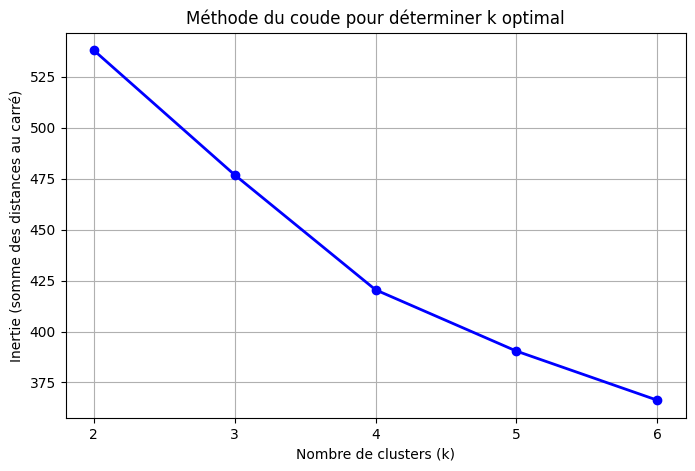

K optimal choisi : 4
   Demographie  Niveau_de_vie  Emploi_activite  Acces à sante générale  \
0     0.000359       0.464537     8.872579e-05                0.073559   
1     0.000133       0.441686     2.804808e-05                0.066398   
2     0.007054       0.395884     1.995629e-02                0.125695   
3     0.000869       0.444173     6.999453e-04                0.089182   
4     0.000052       0.437146     8.258304e-08                0.028879   

   Déprivation aux soins de santé spécialisés  Services_publics   Elevage  \
0                                    0.992953          0.870789  0.014423   
1                                    0.952175          0.851989  0.000000   
2                                    0.878161          0.892177  0.000000   
3                                    0.965559          0.859618  0.000000   
4                                    1.000000          0.853623  0.000000   

   Agriculture  Agriculture biologique  Tourisme  Pollution  
0     0.0

In [23]:

# Copie des données
X_cluster = facteurs_en_groupes.copy()

X_cluster.drop(columns=['codgeo','libgeo','canton'], inplace=True)
X_cluster.head()

# Définition des k à tester
k_values = range(2, 7)
inertias = []

# Calcul des inerties pour chaque k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    inertias.append(kmeans.inertia_)

# Affichage de la courbe du coude
plt.figure(figsize=(8, 5))
plt.plot(list(k_values), inertias, 'bo-', linewidth=2, markersize=6)
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie (somme des distances au carré)")
plt.title("Méthode du coude pour déterminer k optimal")
plt.xticks(list(k_values))
plt.grid(True)
plt.show()

# Détection simple du k optimal : point où la différence d'inertie diminue fortement
diff_inertias = np.diff(inertias)
diff_ratio = diff_inertias[1:] / diff_inertias[:-1]
k_optimal = k_values[np.argmin(diff_ratio) + 1] 

print(f"K optimal choisi : {k_optimal}")

print(X_cluster.head())


In [24]:
# Clustering final
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
X_cluster['Cluster'] = kmeans_final.fit_predict(X_cluster)

# Vérification du résultat
X_cluster.head()

,Demographie,Niveau_de_vie,Emploi_activite,Acces à sante générale,Déprivation aux soins de santé spécialisés,Services_publics,Elevage,Agriculture,Agriculture biologique,Tourisme,Pollution,Cluster
0,0.000359,0.464537,8.872579e-05,0.073559,0.992953,0.870789,0.014423,0.009077,0.000000,0.001073,0.002404,3
1,0.000133,0.441686,2.804808e-05,0.066398,0.952175,0.851989,0.000000,0.011314,0.018727,0.000000,0.014981,3
2,0.007054,0.395884,1.995629e-02,0.125695,0.878161,0.892177,0.000000,0.000407,0.000337,0.000902,0.001212,2
3,0.000869,0.444173,6.999453e-04,0.089182,0.965559,0.859618,0.000000,0.009555,0.000000,0.003765,0.004217,3
4,0.000052,0.437146,8.258304e-08,0.028879,1.000000,0.853623,0.000000,0.000000,0.000000,0.000000,0.053097,2


In [25]:
# Calculer le score silhouette
score_silhouette = silhouette_score(X_cluster.drop(columns='Cluster'), X_cluster['Cluster'])
print(f"Score de silhouette pour k={k_optimal} : {score_silhouette:.4f}")

Score de silhouette pour k=4 : 0.2499


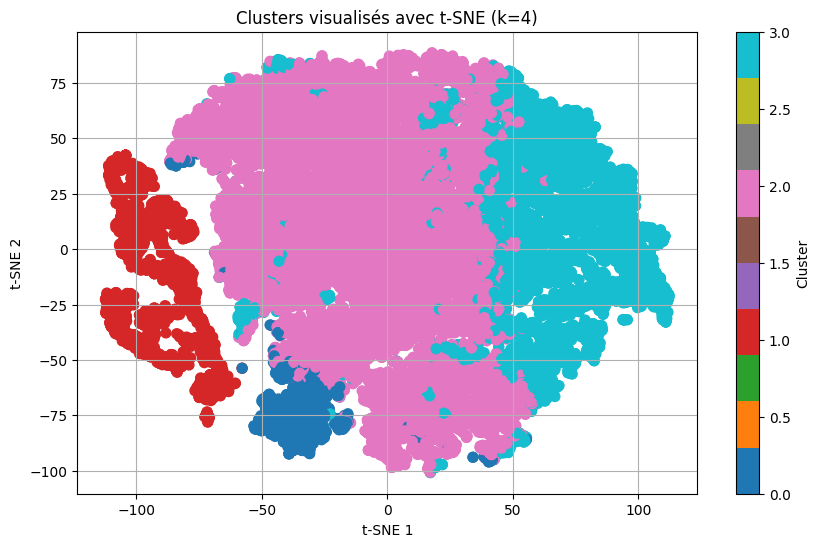

In [26]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_cluster.drop(columns='Cluster'))

plt.figure(figsize=(10,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=X_cluster['Cluster'], cmap='tab10', s=50)
plt.title(f"Clusters visualisés avec t-SNE (k={k_optimal})")
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [67]:
X_cluster.head()

,Demographie,Niveau_de_vie,Emploi_activite,Acces à sante générale,Déprivation aux soins de santé spécialisés,Services_publics,Elevage,Agriculture,Agriculture biologique,Tourisme,Pollution,Cluster
0,0.000359,0.464537,8.872579e-05,0.073559,0.992953,0.870789,0.014423,0.009077,0.000000,0.001073,0.002404,2
1,0.000133,0.441686,2.804808e-05,0.066398,0.952175,0.851989,0.000000,0.011314,0.018727,0.000000,0.014981,3
2,0.007054,0.395884,1.995629e-02,0.125695,0.878161,0.892177,0.000000,0.000407,0.000337,0.000902,0.001212,0
3,0.000869,0.444173,6.999453e-04,0.089182,0.965559,0.859618,0.000000,0.009555,0.000000,0.003765,0.004217,0
4,0.000052,0.437146,8.258304e-08,0.028879,1.000000,0.853623,0.000000,0.000000,0.000000,0.000000,0.053097,3


In [68]:
cols_geo = ['codgeo', 'canton', 'libgeo']

# Ajouter ces colonnes à X_cluster, en s'assurant que les index correspondent
X_cluster = X_cluster.join(factors[cols_geo])

In [69]:
# Correction codgeo et canton
X_cluster['codgeo'] = X_cluster['codgeo'].astype(str).str.replace(r'\.0$', '', regex=True)
X_cluster['canton'] = X_cluster['canton'].astype(str).str.replace(r'\.0$', '', regex=True)

# Ajout d'un zéro devant les codes à 3 chiffres
X_cluster['canton'] = X_cluster['canton'].apply(lambda x: x.zfill(4) if len(x) == 3 else x)
X_cluster['codgeo'] = X_cluster['codgeo'].apply(lambda x: x.zfill(5) if len(x) == 4 else x)

In [70]:
X_cluster.to_csv('tables/facteurs_groupes_cluster_com.csv', index=False)

In [71]:
#clustering au niveau cantonal

In [72]:
factors = pd.read_csv('tables/facteurs_en_groupes.csv')
factors = factors.drop(columns=['libgeo', 'codgeo'])
facteurs_par_canton = factors.groupby('canton').mean().reset_index()

facteurs_par_canton.head()

,canton,Demographie,Niveau_de_vie,Emploi_activite,Acces à sante générale,Déprivation aux soins de santé spécialisés,Services_publics,Elevage,Agriculture,Agriculture biologique,Tourisme,Pollution
0,0101,0.000876,0.404259,0.001679,0.095009,0.970273,0.859637,0.016285,0.008740,0.012400,0.001589,0.009797
1,0102,0.000653,0.441412,0.000633,0.069207,0.989063,0.868526,0.023762,0.006797,0.003058,0.000621,0.002667
2,0103,0.000857,0.490628,0.001218,0.030919,0.941141,0.856573,0.007787,0.010266,0.004790,0.002571,0.003551
3,0104,0.000340,0.386497,0.000548,0.082959,0.990471,0.864742,0.006448,0.015564,0.017324,0.001704,0.016413
4,0105,0.002771,0.463551,0.011385,0.112617,0.968409,0.894342,0.007051,0.004215,0.002203,0.002098,0.003525


In [73]:
# Nettoyage
factors_numeric = facteurs_par_canton.drop(columns=['canton'], errors='ignore')
factors_numeric = factors_numeric.select_dtypes(include=[np.number])
factors_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
factors_numeric.fillna(0, inplace=True)


# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(factors_numeric)


Le nombre optimal de clusters est : 4


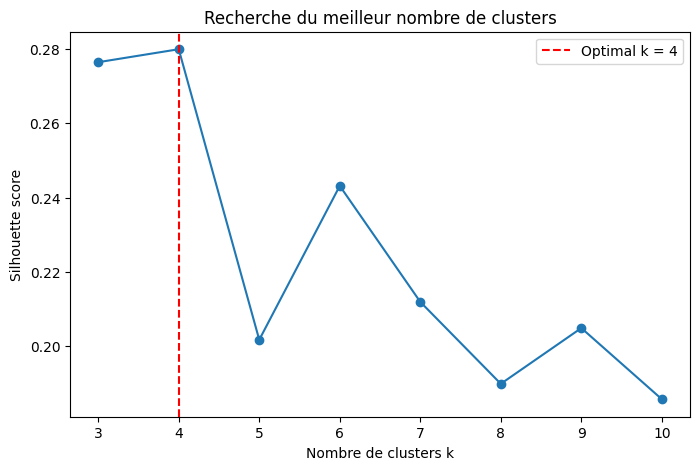

,canton,Demographie,Niveau_de_vie,Emploi_activite,Acces à sante générale,Déprivation aux soins de santé spécialisés,Services_publics,Elevage,Agriculture,Agriculture biologique,Tourisme,Pollution,Cluster
0,0101,0.000876,0.404259,0.001679,0.095009,0.970273,0.859637,0.016285,0.008740,0.012400,0.001589,0.009797,0
1,0102,0.000653,0.441412,0.000633,0.069207,0.989063,0.868526,0.023762,0.006797,0.003058,0.000621,0.002667,0
2,0103,0.000857,0.490628,0.001218,0.030919,0.941141,0.856573,0.007787,0.010266,0.004790,0.002571,0.003551,0
3,0104,0.000340,0.386497,0.000548,0.082959,0.990471,0.864742,0.006448,0.015564,0.017324,0.001704,0.016413,0
4,0105,0.002771,0.463551,0.011385,0.112617,0.968409,0.894342,0.007051,0.004215,0.002203,0.002098,0.003525,0


In [74]:

# ---------------------
# Recherche du meilleur nombre de clusters via silhouette score
# ---------------------
sil_scores = []
K_range = range(3, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

# k optimal
optimal_k = K_range[np.argmax(sil_scores)]
print(f"Le nombre optimal de clusters est : {optimal_k}")

# ---------------------
# Affichage du graphique
# ---------------------
plt.figure(figsize=(8,5))
plt.plot(K_range, sil_scores, marker='o')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.xlabel('Nombre de clusters k')
plt.ylabel('Silhouette score')
plt.title('Recherche du meilleur nombre de clusters')
plt.legend()
plt.show()

# ---------------------
# Appliquer K-Means avec k optimal et ajouter les labels
# ---------------------
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
facteurs_par_canton['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Vérification
facteurs_par_canton.head()


In [75]:
labels_kmeans = facteurs_par_canton['Cluster']  # ou factors_reduit['Cluster']
score_kmeans = silhouette_score(X_scaled, labels_kmeans)
print(f"Silhouette score KMeans : {score_kmeans:.3f}")

Silhouette score KMeans : 0.280


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


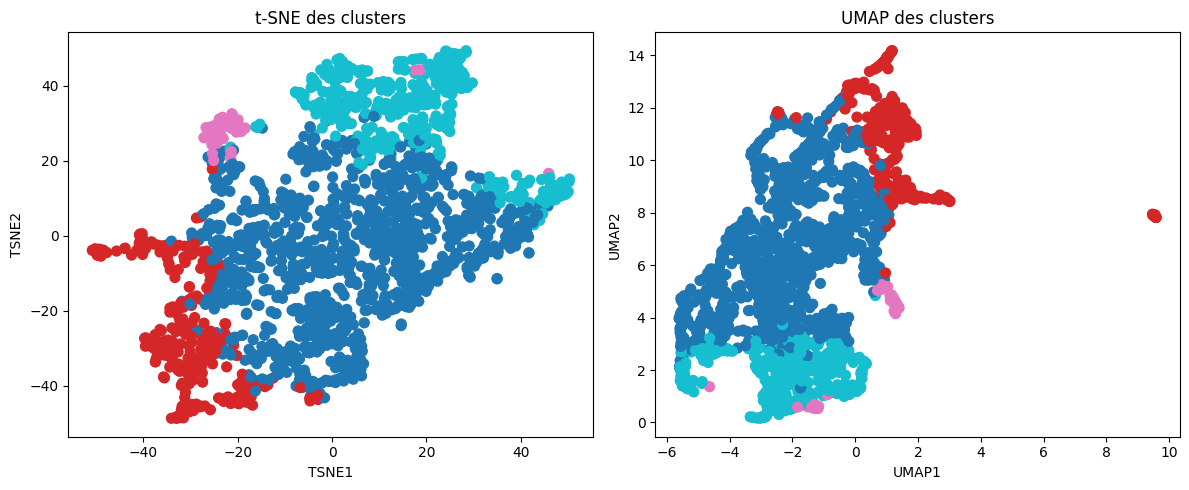

In [76]:
# ---------------------
# t-SNE
# ---------------------
tsne = TSNE(n_components=2, random_state=42, init='random')
tsne_result = tsne.fit_transform(X_scaled)  # X_scaled utilisé pour le clustering
facteurs_par_canton['TSNE1'] = tsne_result[:, 0]
facteurs_par_canton['TSNE2'] = tsne_result[:, 1]

# ---------------------
# UMAP
# ---------------------
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(X_scaled)
facteurs_par_canton['UMAP1'] = umap_result[:, 0]
facteurs_par_canton['UMAP2'] = umap_result[:, 1]

# ---------------------
# Visualisation des clusters
# ---------------------
plt.figure(figsize=(12,5))

# t-SNE
plt.subplot(1,2,1)
plt.scatter(facteurs_par_canton['TSNE1'], facteurs_par_canton['TSNE2'],
            c=facteurs_par_canton['Cluster'], cmap='tab10', s=50)
plt.title('t-SNE des clusters')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')

# UMAP
plt.subplot(1,2,2)
plt.scatter(facteurs_par_canton['UMAP1'], facteurs_par_canton['UMAP2'],
            c=facteurs_par_canton['Cluster'], cmap='tab10', s=50)
plt.title('UMAP des clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.tight_layout()
plt.show()

In [77]:
# Réintégrer la colonne 'canton' si besoin
canton_col = facteurs_par_canton['canton'].copy()
facteurs_par_canton['canton'] = canton_col

# Supprimer les colonnes t-SNE et UMAP
cols_to_drop = ['TSNE1', 'TSNE2', 'UMAP1', 'UMAP2']
facteurs_par_canton.drop(columns=[col for col in cols_to_drop if col in facteurs_par_canton.columns], inplace=True)

# Vérification
facteurs_par_canton.head()


,canton,Demographie,Niveau_de_vie,Emploi_activite,Acces à sante générale,Déprivation aux soins de santé spécialisés,Services_publics,Elevage,Agriculture,Agriculture biologique,Tourisme,Pollution,Cluster
0,0101,0.000876,0.404259,0.001679,0.095009,0.970273,0.859637,0.016285,0.008740,0.012400,0.001589,0.009797,0
1,0102,0.000653,0.441412,0.000633,0.069207,0.989063,0.868526,0.023762,0.006797,0.003058,0.000621,0.002667,0
2,0103,0.000857,0.490628,0.001218,0.030919,0.941141,0.856573,0.007787,0.010266,0.004790,0.002571,0.003551,0
3,0104,0.000340,0.386497,0.000548,0.082959,0.990471,0.864742,0.006448,0.015564,0.017324,0.001704,0.016413,0
4,0105,0.002771,0.463551,0.011385,0.112617,0.968409,0.894342,0.007051,0.004215,0.002203,0.002098,0.003525,0


In [78]:
facteurs_par_canton.to_csv('tables/facteurs_groupes_cluster_can.csv', index=False)